2025-06-15 13:27:28,219 - INFO -  Début du pipeline K-means amélioré
2025-06-15 13:27:29,610 - INFO - 267468 vecteurs ACP chargés
2025-06-15 13:27:59,256 - INFO - k=2 → silhouette=0.3855
2025-06-15 13:28:26,931 - INFO - k=3 → silhouette=0.3726
2025-06-15 13:28:54,305 - INFO - k=4 → silhouette=0.3380
2025-06-15 13:29:21,585 - INFO - k=5 → silhouette=0.3060
2025-06-15 13:29:48,460 - INFO - k=6 → silhouette=0.2527
2025-06-15 13:30:15,471 - INFO - k=7 → silhouette=0.2866
2025-06-15 13:30:42,547 - INFO - k=8 → silhouette=0.2796
2025-06-15 13:31:09,453 - INFO - k=9 → silhouette=0.2530
2025-06-15 13:31:36,286 - INFO - k=10 → silhouette=0.2513
2025-06-15 13:31:36,287 - INFO -  Meilleur k = 2
2025-06-15 13:31:38,945 - INFO -  Clusters sauvegardés dans 'acp_clusters'
2025-06-15 13:31:38,960 - INFO -  Moyennes des composantes par cluster :
          PC1   PC2   PC3   PC4   PC5
cluster                              
0        1.04 -0.05 -0.03  0.04  0.10
1       -1.75  0.09  0.04 -0.07 -0.16
2025-06

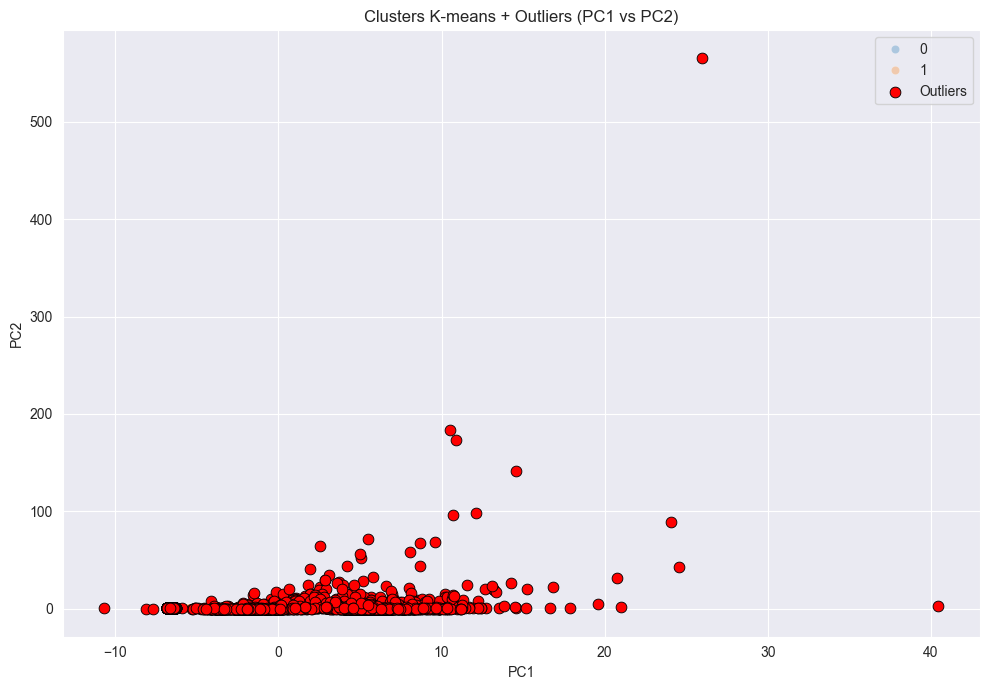

2025-06-15 13:41:51,211 - INFO -  Connexion MongoDB fermée
2025-06-15 13:41:51,212 - INFO -  Pipeline K-means terminé avec succès


In [2]:
import os
import logging
from datetime import datetime
from pymongo import MongoClient
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, pairwise_distances_argmin_min
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Environnement ===
def setup_environment():
    os.makedirs("logs", exist_ok=True)
    os.makedirs("images", exist_ok=True)
    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s - %(levelname)s - %(message)s",
        handlers=[
            logging.FileHandler(f"logs/kmeans_pipeline_{datetime.now():%Y%m%d_%H%M%S}.log", encoding="utf-8"),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger(__name__)

logger = setup_environment()
logger.info(" Début du pipeline K-means amélioré")

try:
    # === 2. Connexion MongoDB ===
    client = MongoClient("localhost", 27017)
    db = client["IF29_twitter_db"]
    collection = db["acp_db"]

    fields = {"_id": 1, "PC1": 1, "PC2": 1, "PC3": 1, "PC4": 1, "PC5": 1}
    data = pd.DataFrame(list(collection.find({}, fields)))

    if data.empty:
        raise ValueError(" Aucune donnée trouvée dans 'acp_db'")

    ids = data.pop("_id")
    logger.info(f"{len(data)} vecteurs ACP chargés")

    # === 3. Choix de k optimal (silhouette) ===
    sample = data.sample(frac=0.2, random_state=42) if len(data) > 10000 else data
    silhouette_scores = []
    k_range = range(2, 11)

    for k in k_range:
        model = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=2048, n_init="auto")
        labels = model.fit_predict(sample)
        score = silhouette_score(sample, labels)
        silhouette_scores.append(score)
        logger.info(f"k={k} → silhouette={score:.4f}")

    best_k = k_range[silhouette_scores.index(max(silhouette_scores))]
    logger.info(f" Meilleur k = {best_k}")

    # === 4. Clustering final ===
    model = MiniBatchKMeans(n_clusters=best_k, random_state=42, batch_size=2048, n_init="auto")
    data["cluster"] = model.fit_predict(data)
    data["_id"] = ids

    db.drop_collection("acp_clusters")
    db["acp_clusters"].insert_many(data.to_dict("records"))
    logger.info(" Clusters sauvegardés dans 'acp_clusters'")

    # === 5. Analyse des clusters ===
    # Sélectionne seulement les colonnes numériques pour éviter l'erreur
    numerical_cols = data.select_dtypes(include='number').columns.difference(['cluster'])
    cluster_stats = data.groupby("cluster")[numerical_cols].mean().round(2)

    logger.info(" Moyennes des composantes par cluster :\n" + str(cluster_stats))

    # === 6. Détection des outliers PAR CLUSTER ===
    logger.info(" Détection des outliers par cluster...")
    data["distance"] = pairwise_distances_argmin_min(
        data[["PC1", "PC2", "PC3", "PC4", "PC5"]],
        model.cluster_centers_[data["cluster"]]
    )[1]

    # Marquage des outliers dans chaque cluster
    data["is_outlier"] = False
    for cluster_id in data["cluster"].unique():
        seuil = data[data["cluster"] == cluster_id]["distance"].quantile(0.99)
        data.loc[(data["cluster"] == cluster_id) & (data["distance"] >= seuil), "is_outlier"] = True

    n_outliers = data["is_outlier"].sum()
    logger.info(f" {n_outliers} outliers détectés (top 1% dans chaque cluster)")

    # Sauvegarde
    db.drop_collection("acp_outliers")
    db["acp_outliers"].insert_many(data[data["is_outlier"]].to_dict("records"))
    logger.info(" Profils atypiques sauvegardés dans 'acp_outliers'")

    # === 7. Visualisation : clusters + outliers ===
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=data, x="PC1", y="PC2", hue="cluster", palette="tab10", alpha=0.3)
    sns.scatterplot(data=data[data["is_outlier"]], x="PC1", y="PC2", color="red", edgecolor="black", label="Outliers", s=60)
    plt.title("Clusters K-means + Outliers (PC1 vs PC2)")
    plt.tight_layout()
    plt.savefig("images/kmeans_outliers_pc1_pc2.png")
    plt.show()

except Exception as e:
    logger.error(f" Erreur dans le pipeline : {e}")
    raise

finally:
    client.close()
    logger.info(" Connexion MongoDB fermée")
    logger.info(" Pipeline K-means terminé avec succès")


In [5]:
from pymongo import MongoClient
import pandas as pd

# === Étape 1 : Connexion MongoDB ===
client = MongoClient("localhost", 27017)
db = client["IF29_twitter_db"]

# === Étape 2 : Charger les outliers détectés via ACP ===
outliers_df = pd.DataFrame(list(db["acp_outliers"].find()))
print(f"{len(outliers_df)} outliers chargés depuis 'acp_outliers'")

# === Étape 3 : Associer user_id depuis acp_db ===
acp_db_df = pd.DataFrame(list(db["acp_db"].find({}, {"_id": 1, "user_id": 1})))
outliers_with_uid = pd.merge(outliers_df, acp_db_df, on="_id", how="left")
print(f"{outliers_with_uid['user_id'].notna().sum()} user_id associés via 'acp_db'")

# === Étape 4 : Charger user_db pour features calculées ===
user_db_df = pd.DataFrame(list(db["user_db"].find()))
merged_user_info = pd.merge(
    outliers_with_uid,
    user_db_df,
    left_on="user_id",
    right_on="_id",
    how="left"
)

# === Étape 5 : Enrichir avec twitter_users ===
twitter_users_df = pd.DataFrame(list(db["twitter_users"].find()))
twitter_users_df["id"] = pd.to_numeric(twitter_users_df["id"], errors="coerce")
merged_user_info["id"] = pd.to_numeric(merged_user_info["id"], errors="coerce")

final_df = pd.merge(
    merged_user_info,
    twitter_users_df[["id", "screen_name", "verified", "description"]],
    on="id",
    how="left"
)

# === Étape 6 : Trier les plus atypiques ===
top_outliers = final_df.sort_values("distance", ascending=False).head(10)

# === Étape 7 : Affichage final ===
result_df = top_outliers[[
    "screen_name", "verified", "description",
    "followers_count", "friends_count", "tweets_per_day", "distance"
]]

pd.set_option("display.max_colwidth", 150)
print("\nTop 10 profils les plus atypiques (ACP – K-Means) enrichis :\n")
print(result_df.to_string(index=False))


2676 outliers chargés depuis 'acp_outliers'
2676 user_id associés via 'acp_db'

Top 10 profils les plus atypiques (ACP – K-Means) enrichis :

    screen_name  verified                                                                                                                                                     description  followers_count  friends_count  tweets_per_day   distance
        sabqorg      True الحساب الرسمي لصحيفة سبق الإلكترونية، Sabq Apps: http://land.ly/sabq - للإعلان في شبكات التواصل trend@sabq.org - سناب شات https://www.snapchat.com/add/sabq_org         13116345              2       23.558737 579.350310
   alsulima0chw     False                                                                                                                                                 alsulima0chw 😘😊            14236           1691        0.000265 263.340844
        kiivzz1     False                                                                                                  

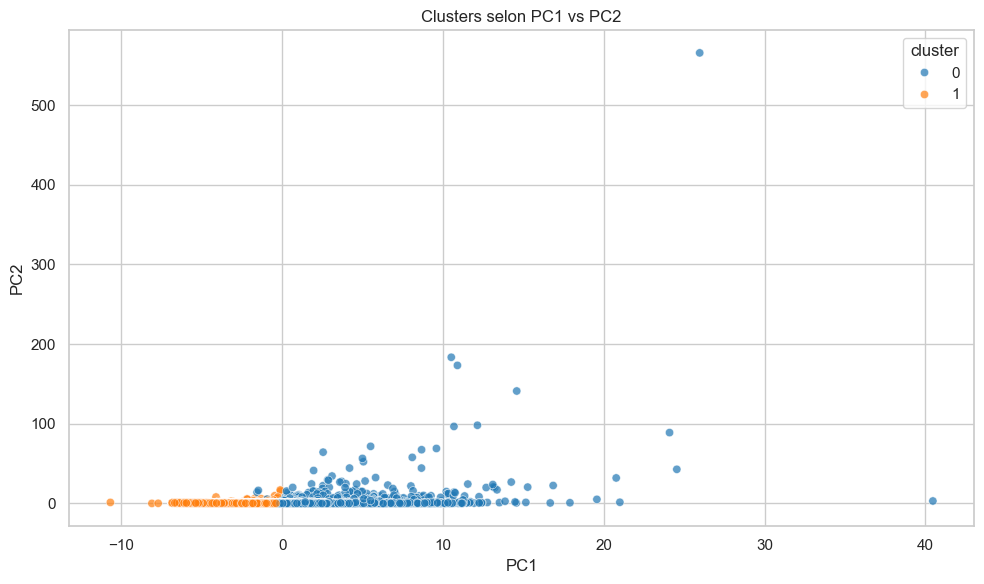

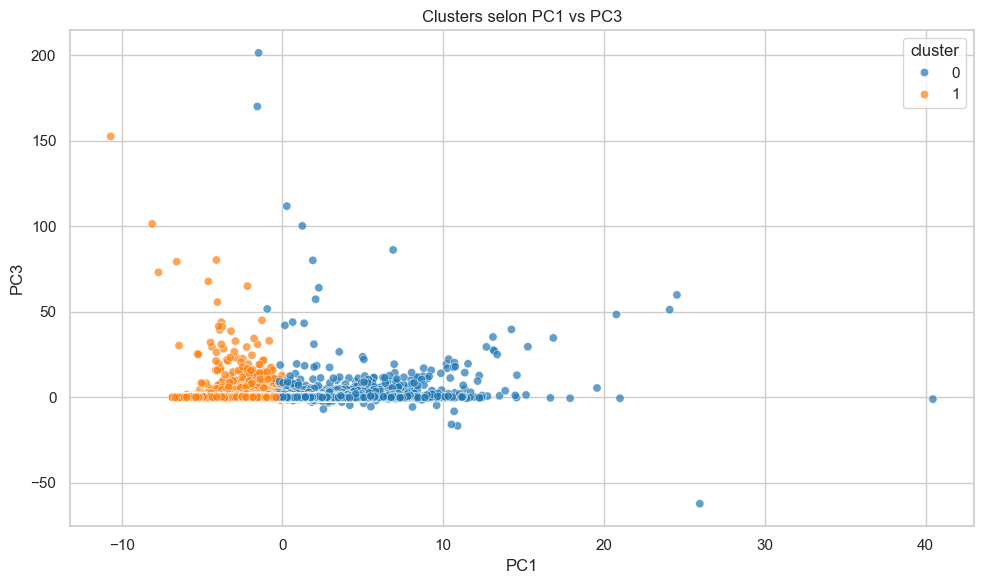

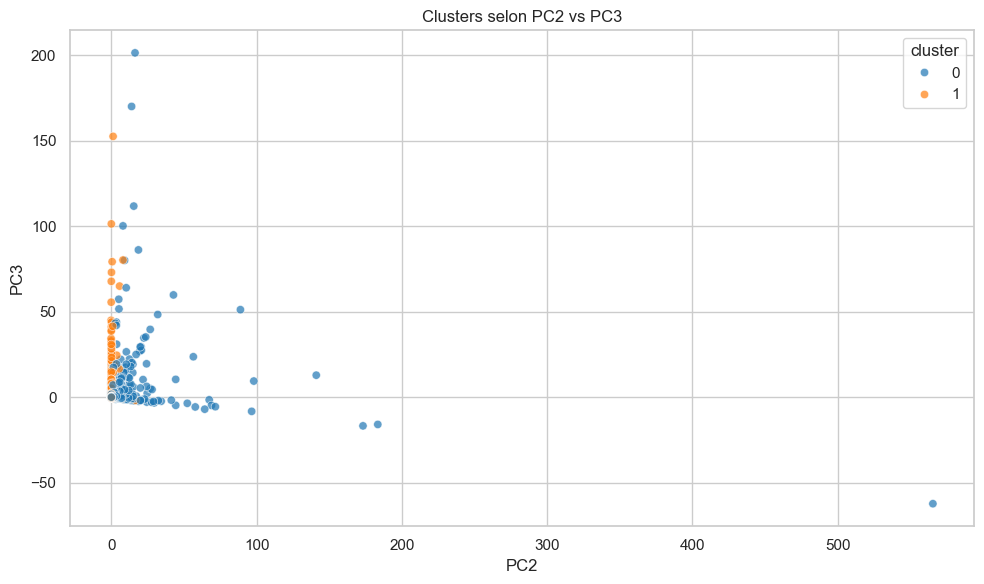

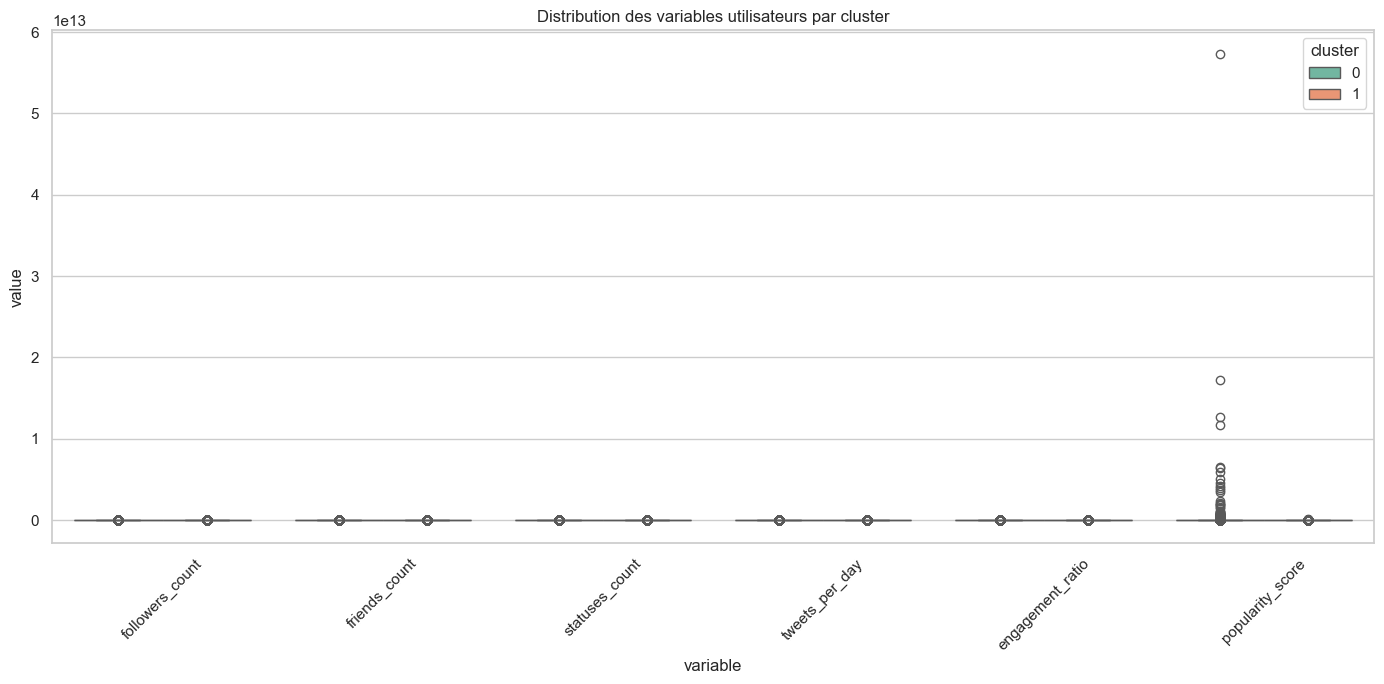

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient

# Connexion MongoDB
client = MongoClient("localhost", 27017)
db = client["IF29_twitter_db"]

# Chargement des données nécessaires
acp_df = pd.DataFrame(list(db["acp_db"].find({}, {
    "_id": 1, "user_id": 1, "PC1": 1, "PC2": 1, "PC3": 1, "PC4": 1, "PC5": 1
})))

clusters_df = pd.DataFrame(list(db["acp_clusters"].find({}, {
    "_id": 1, "cluster": 1
})))

users_df = pd.DataFrame(list(db["user_db"].find({}, {
    "_id": 1,
    "followers_count": 1,
    "friends_count": 1,
    "statuses_count": 1,
    "tweets_per_day": 1,
    "engagement_ratio": 1,
    "popularity_score": 1
})))

# Fusion des données
merged = pd.merge(acp_df, clusters_df, on="_id", how="left")
merged = pd.merge(merged, users_df, left_on="user_id", right_on="_id", how="left")
merged.drop(columns=["_id_x", "_id_y"], inplace=True)

# === Visualisation des clusters ===
sns.set(style="whitegrid")

# PC1 vs PC2
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged, x="PC1", y="PC2", hue="cluster", palette="tab10", alpha=0.7)
plt.title("Clusters selon PC1 vs PC2")
plt.tight_layout()
plt.show()

# PC1 vs PC3
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged, x="PC1", y="PC3", hue="cluster", palette="tab10", alpha=0.7)
plt.title("Clusters selon PC1 vs PC3")
plt.tight_layout()
plt.show()

# PC2 vs PC3
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged, x="PC2", y="PC3", hue="cluster", palette="tab10", alpha=0.7)
plt.title("Clusters selon PC2 vs PC3")
plt.tight_layout()
plt.show()

# === Interprétation avec boxplots ===
features = [
    "followers_count", "friends_count", "statuses_count",
    "tweets_per_day", "engagement_ratio", "popularity_score"
]

melted = merged.melt(id_vars="cluster", value_vars=features)
plt.figure(figsize=(14, 7))
sns.boxplot(x="variable", y="value", hue="cluster", data=melted, palette="Set2")
plt.xticks(rotation=45)
plt.title("Distribution des variables utilisateurs par cluster")
plt.tight_layout()
plt.show()


In [7]:
import pandas as pd
from pymongo import MongoClient

# Connexion
client = MongoClient("localhost", 27017)
db = client["IF29_twitter_db"]

# Chargement des clusters
clusters_df = pd.DataFrame(list(db["acp_clusters"].find({}, {"_id": 1, "cluster": 1})))

# Chargement de la table ACP avec user_id
acp_df = pd.DataFrame(list(db["acp_db"].find({}, {"_id": 1, "user_id": 1})))

# Fusion pour retrouver user_id
clusters_df = pd.merge(clusters_df, acp_df, on="_id", how="left")

# Chargement des variables du user
user_df = pd.DataFrame(list(db["user_db"].find()))

# Merge final
full_df = pd.merge(clusters_df, user_df, left_on="user_id", right_on="_id", how="left")

# Liste des variables à analyser
variables = [
    "followers_count", "friends_count", "statuses_count",
    "tweets_per_day", "engagement_ratio", "popularity_score",
    "favorites_per_tweet", "followers_friends_ratio"
]

# Moyenne par cluster
cluster_stats = full_df.groupby("cluster")[variables].mean().round(2)
print("\n Moyenne des variables par cluster :\n")
print(cluster_stats)



 Moyenne des variables par cluster :

         followers_count  friends_count  statuses_count  tweets_per_day  \
cluster                                                                   
0               12285.43        1598.80        34063.14            7.23   
1                 320.37         264.67         2217.68            0.62   

         engagement_ratio  popularity_score  favorites_per_tweet  \
cluster                                                            
0                    1.13      1.108305e+09                 0.99   
1                    1.13      4.674735e+06                 3.07   

         followers_friends_ratio  
cluster                           
0                         247.14  
1                          39.86  


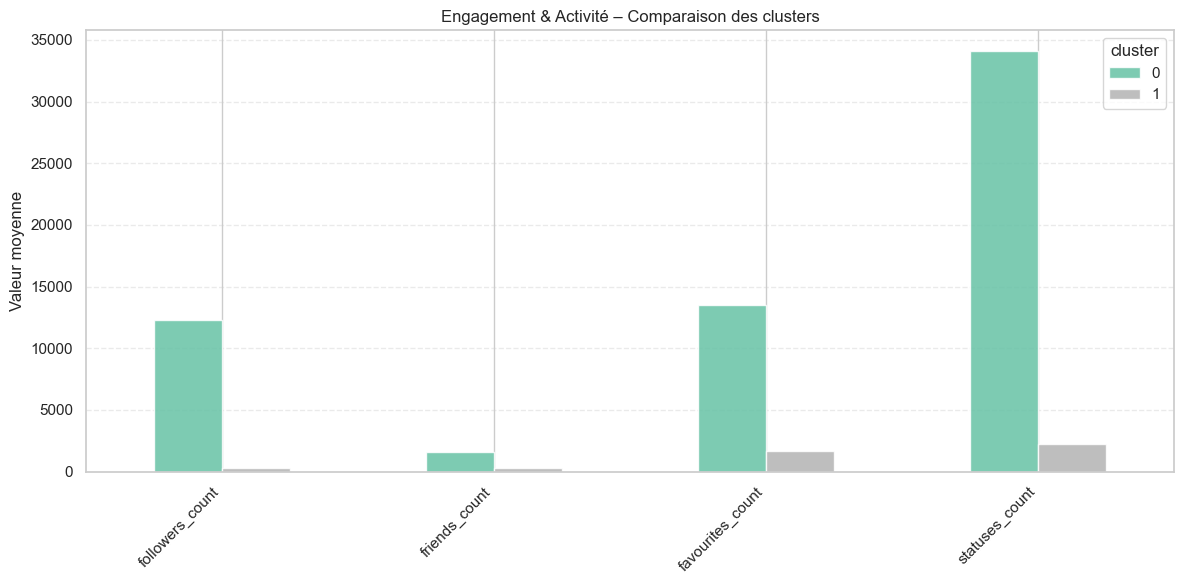

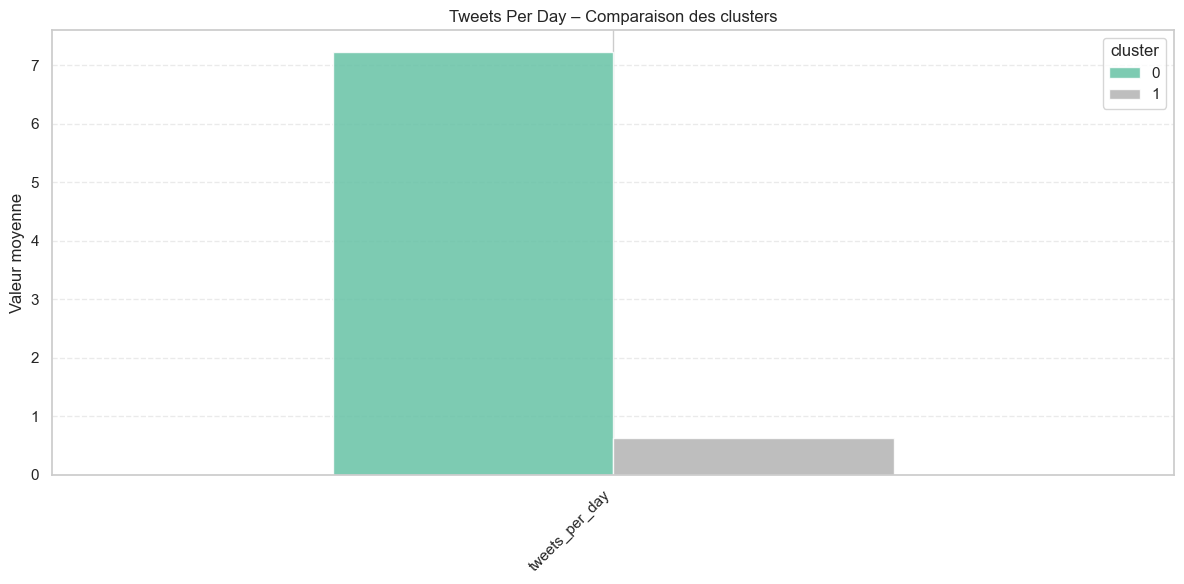

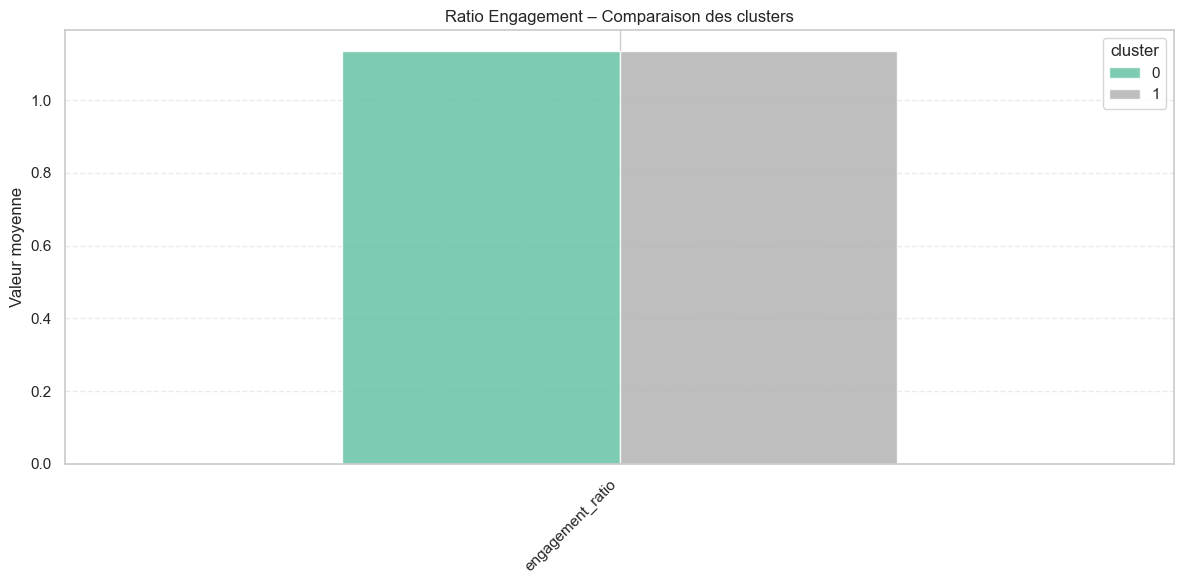

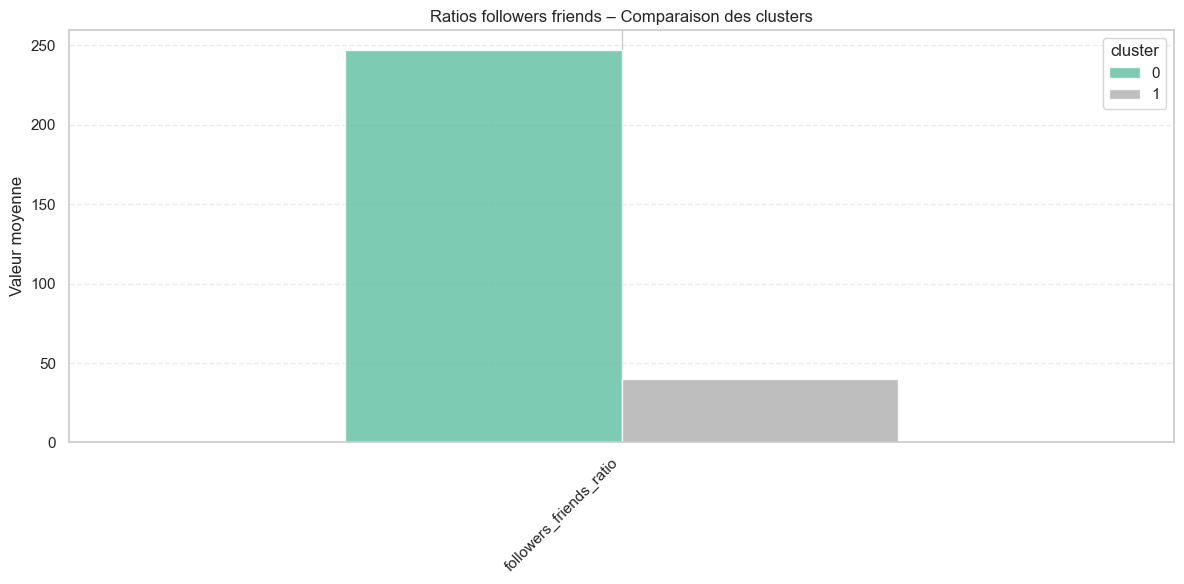

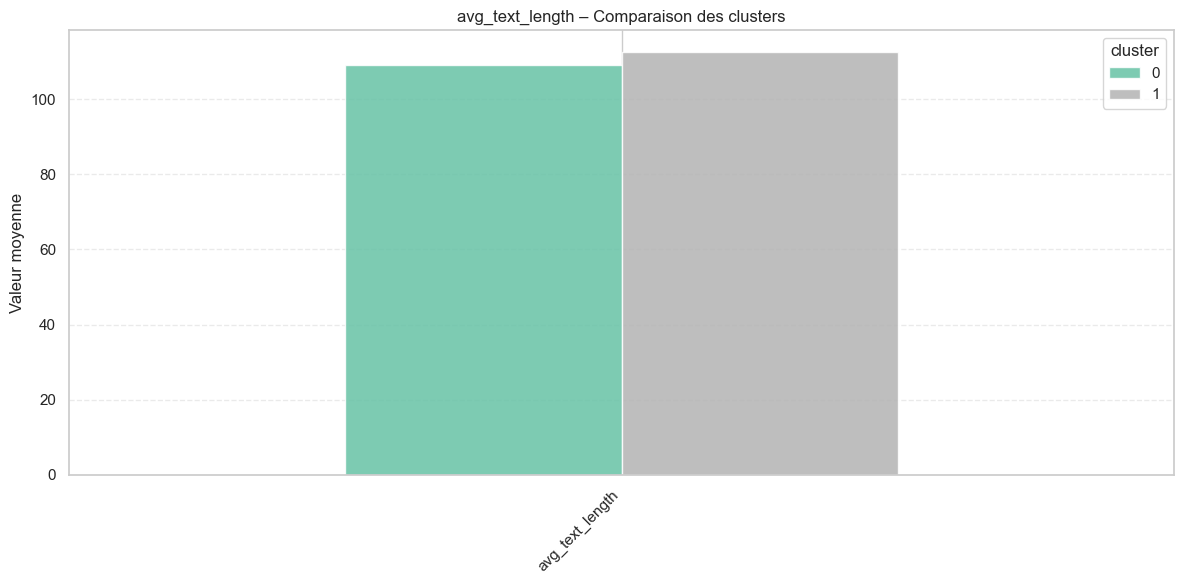

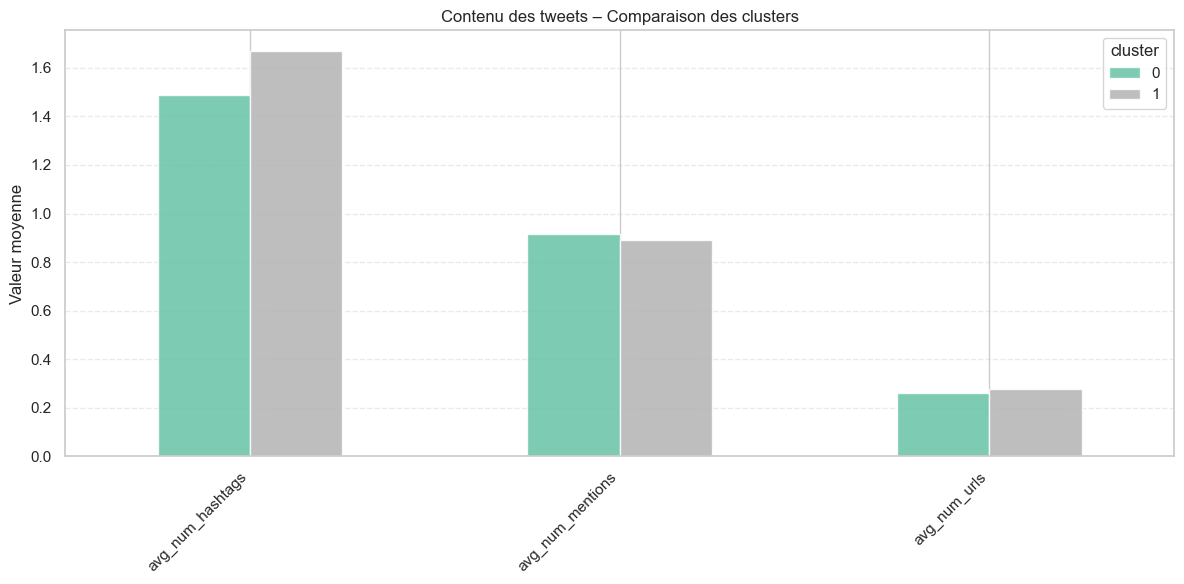

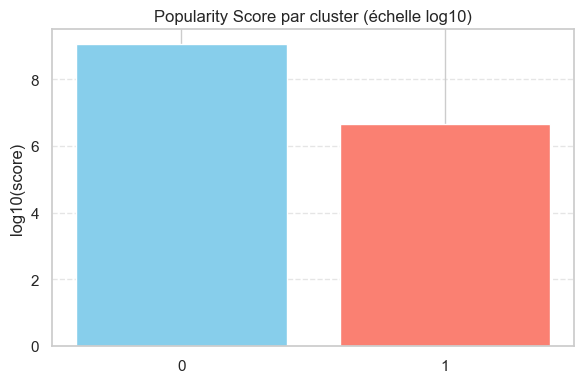

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Définir les groupes thématiques (mêmes variables que dans ta moyenne globale)
groupes = {
    "Engagement & Activité": [
        "followers_count", "friends_count", "favourites_count",
        "statuses_count"
    ],
    "Tweets Per Day": [
        "tweets_per_day"
    ],
    "Ratio Engagement": [
        "engagement_ratio"
    ],
    "Ratios followers friends": [
        "followers_friends_ratio"
    ],
    "avg_text_length": [
        "avg_text_length"
    ],
    "Contenu des tweets": [
        "avg_num_hashtags", "avg_num_mentions", "avg_num_urls"
    ]
}

# Étape 1 : Garder uniquement les colonnes numériques pour éviter l'erreur
numeric_df = full_df.select_dtypes(include=[np.number])

# Étape 2 : Ajouter la colonne "cluster" (si elle a été retirée dans la sélection)
numeric_df["cluster"] = full_df["cluster"]

# Étape 3 : Calcul des moyennes par cluster
cluster_means = numeric_df.groupby("cluster").mean()

# Étape 4 : Tracer les graphiques par groupe
for nom_groupe, colonnes in groupes.items():
    # Vérification que toutes les colonnes sont bien présentes
    colonnes_existantes = [col for col in colonnes if col in cluster_means.columns]
    if not colonnes_existantes:
        continue  # on saute le groupe si rien à tracer

    # Transposer pour graphique (variables sur l'axe X)
    sub_df = cluster_means[colonnes_existantes].T

    sub_df.plot(
        kind="bar",
        figsize=(12, 6),
        title=f"{nom_groupe} – Comparaison des clusters",
        colormap="Set2",
        alpha=0.85
    )
    plt.ylabel("Valeur moyenne")
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.savefig(f"images/comparaison_clusters_{nom_groupe.replace(' ', '_').lower()}.png")
    plt.show()

# Optionnel : Score de popularité avec log10
if "popularity_score" in cluster_means.columns:
    plt.figure(figsize=(6, 4))
    scores = cluster_means["popularity_score"].apply(lambda x: np.log10(x + 1))

    plt.bar(
        scores.index.astype(str),
        scores.values,
        color=["skyblue", "salmon"]
    )
    plt.title("Popularity Score par cluster (échelle log10)")
    plt.ylabel("log10(score)")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig("images/popularity_score_log10_clusters.png")
    plt.show()


In [15]:
import pandas as pd
from pymongo import MongoClient

# Connexion MongoDB
client = MongoClient("localhost", 27017)
db = client["IF29_twitter_db"]

# Chargement des outliers détectés par K-Means (ACP)
outliers_df = pd.DataFrame(list(db["acp_outliers"].find()))
acp_db_df = pd.DataFrame(list(db["acp_db"].find({}, {"_id": 1, "user_id": 1})))

# Associer user_id aux outliers
outliers_df = pd.merge(outliers_df, acp_db_df, on="_id", how="left")

# Charger user_db pour enrichissement
user_db_df = pd.DataFrame(list(db["user_db"].find()))

# Fusion des données
outliers_enriched = pd.merge(outliers_df, user_db_df, left_on="user_id", right_on="_id", how="left")

# Variables d’intérêt
variables = [
    "followers_count", "friends_count", "statuses_count", "favourites_count",
    "tweets_per_day", "engagement_ratio", "followers_friends_ratio",
    "favorites_per_tweet", "popularity_score"
]

# Moyenne des variables pour chaque cluster
cluster_means = outliers_enriched.groupby("cluster")[variables].mean().round(2)

# Affichage final
print("\n=== Moyenne des variables par cluster (Outliers ACP + KMeans) ===\n")
print(cluster_means)



=== Moyenne des variables par cluster (Outliers ACP + KMeans) ===

         followers_count  friends_count  statuses_count  favourites_count  \
cluster                                                                     
0              721672.77       15514.86       360655.63          54925.58   
1                4428.96         156.15          523.82           7197.60   

         tweets_per_day  engagement_ratio  followers_friends_ratio  \
cluster                                                              
0                 74.73             71.08                 21818.03   
1                  0.13             46.51                  1708.41   

         favorites_per_tweet  popularity_score  
cluster                                         
0                       5.22      1.099010e+11  
1                      96.57      3.611737e+08  



 Graphe pour le Cluster 0


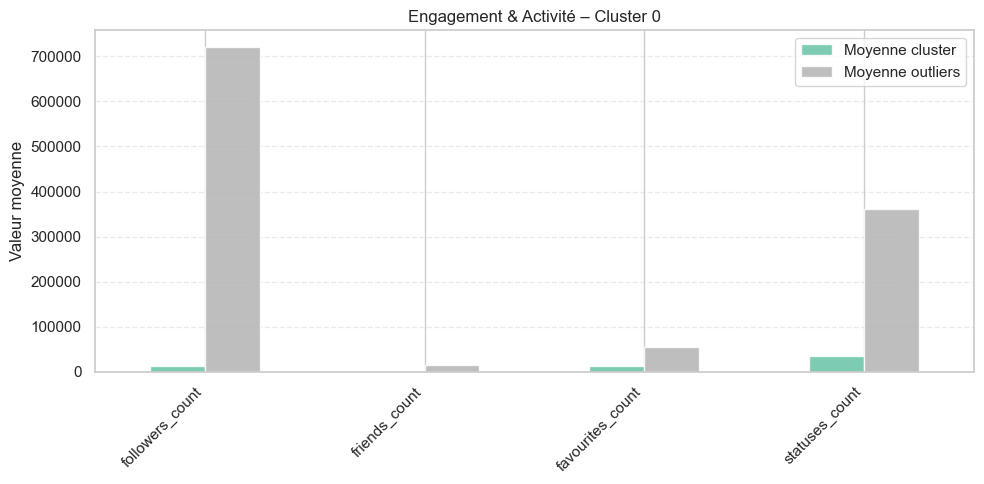

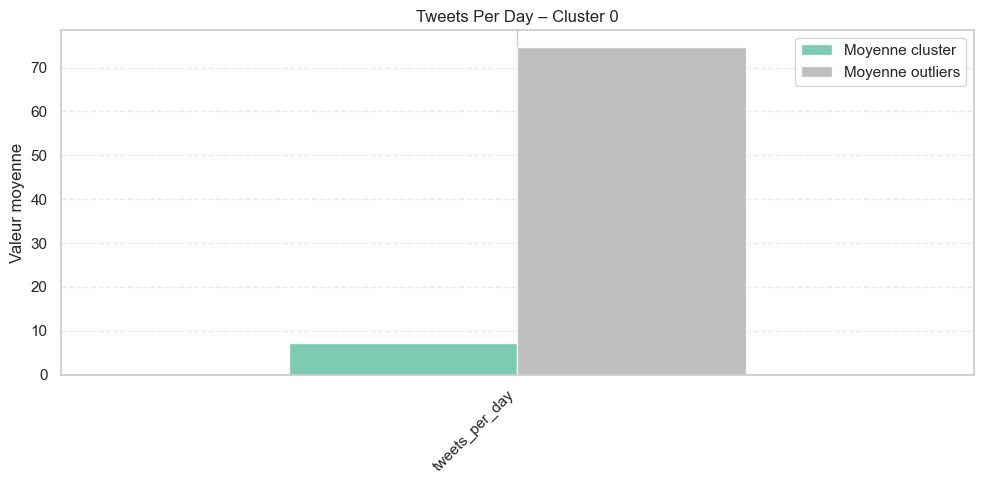

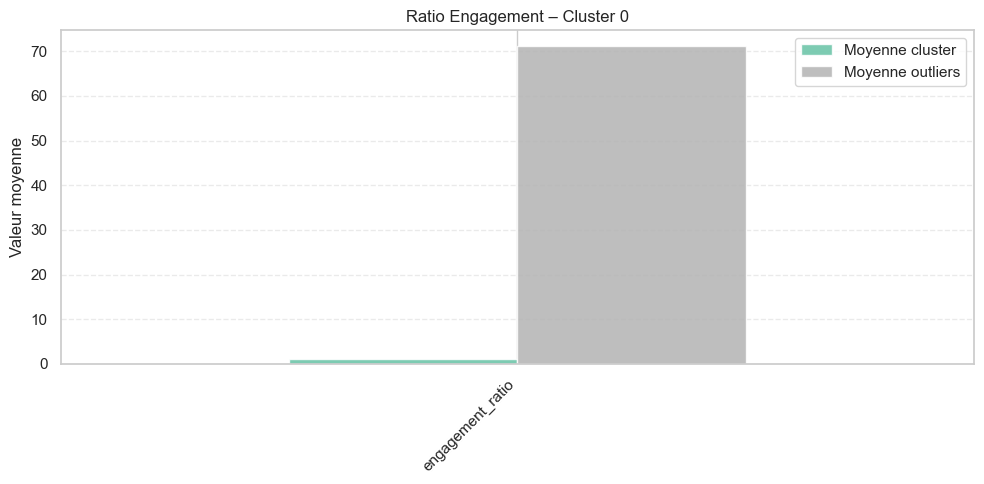

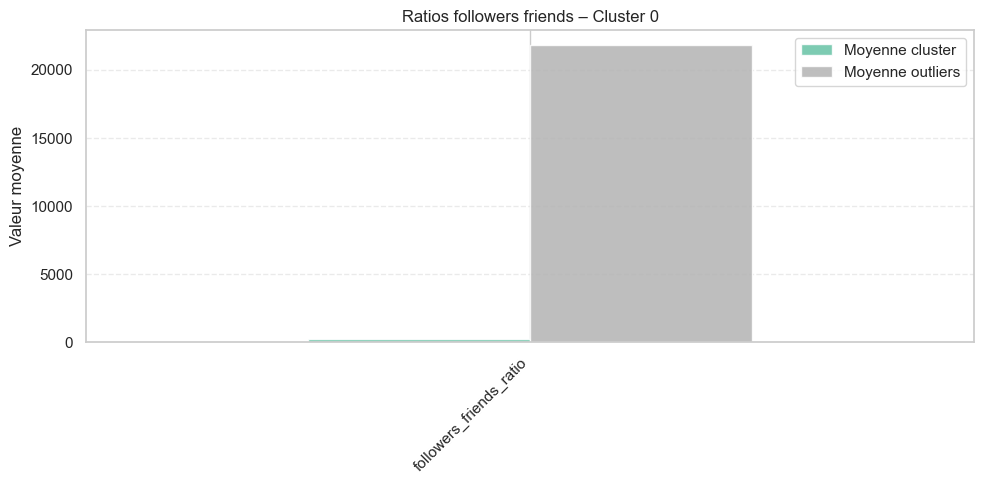

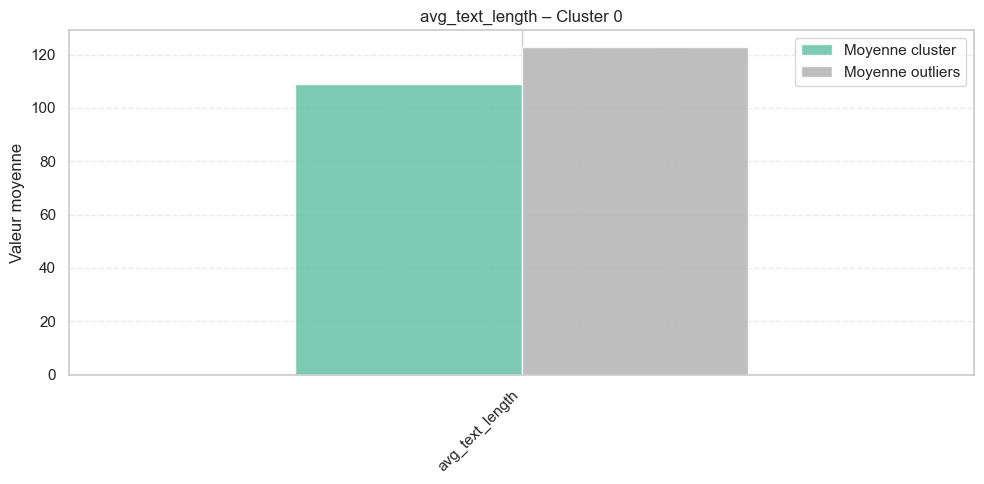

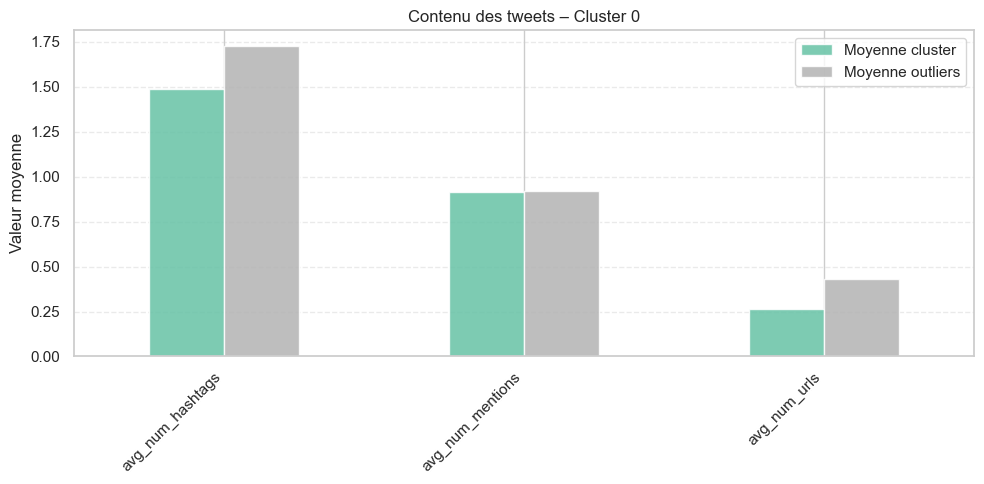


 Graphe pour le Cluster 1


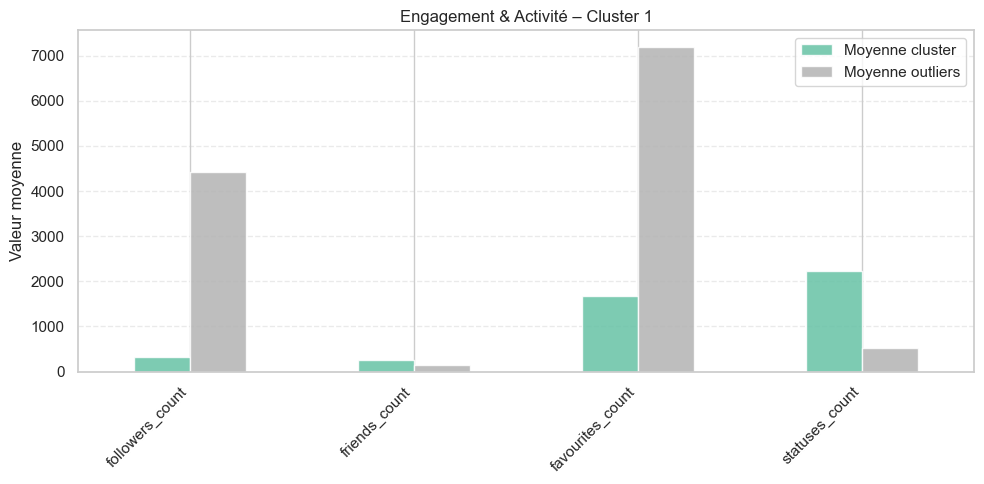

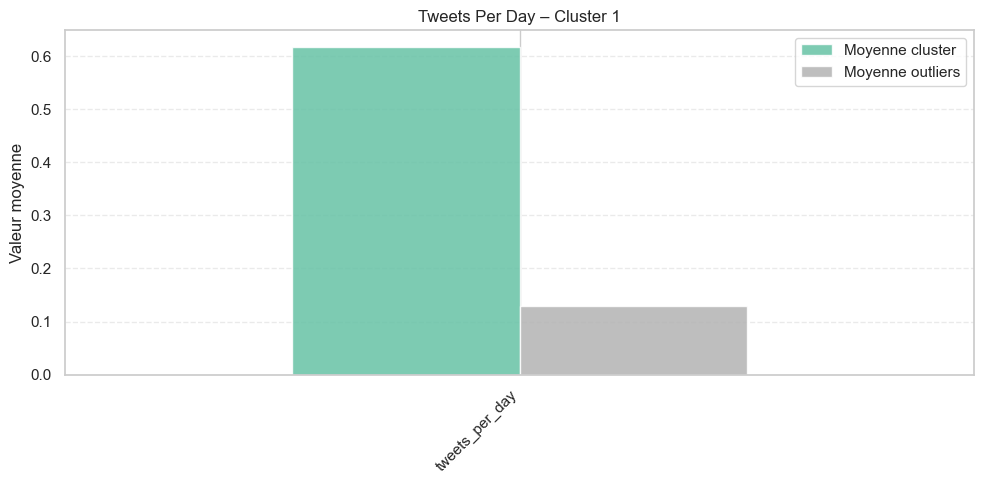

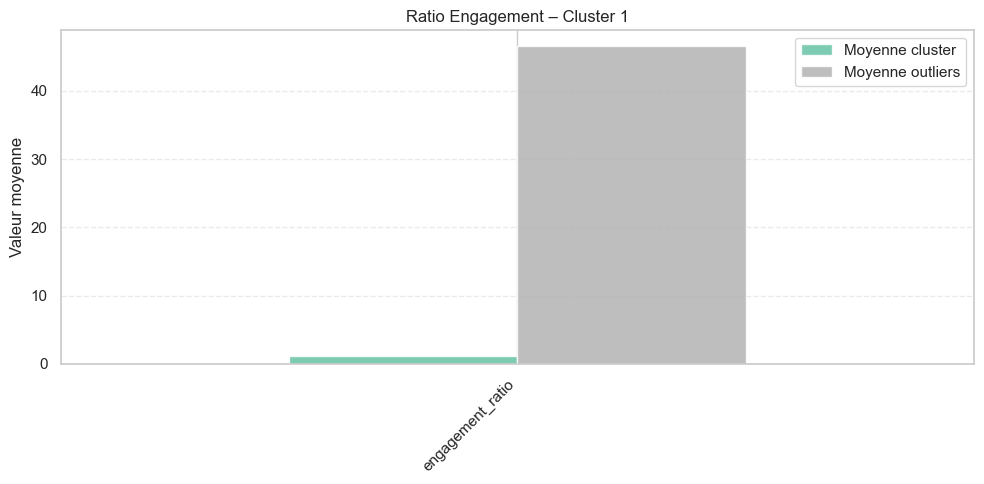

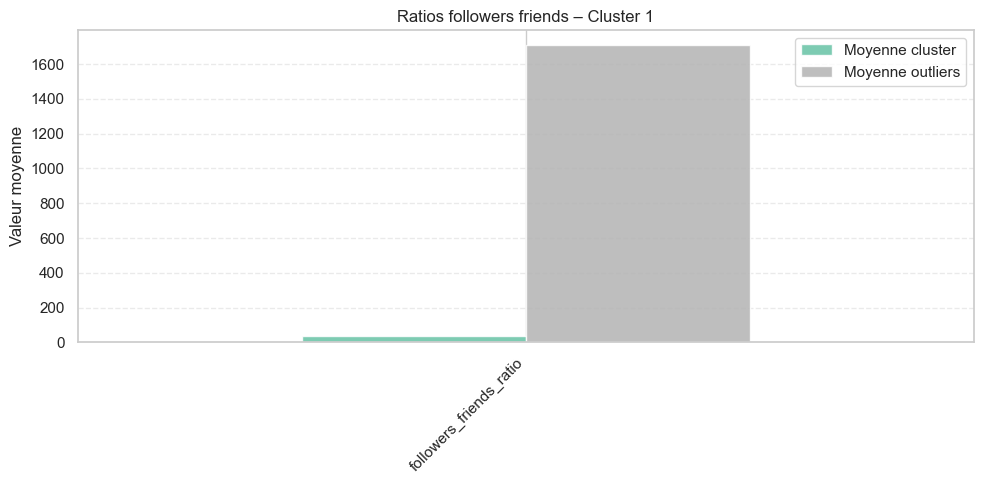

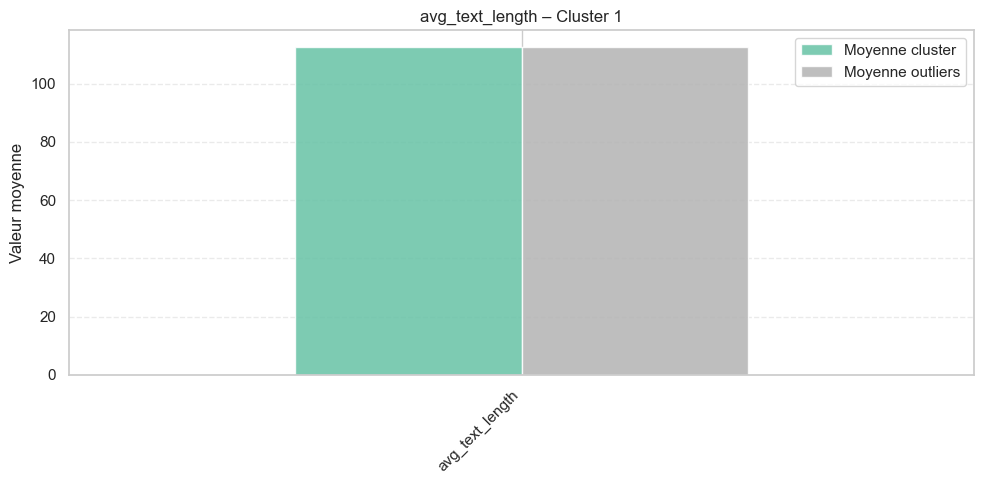

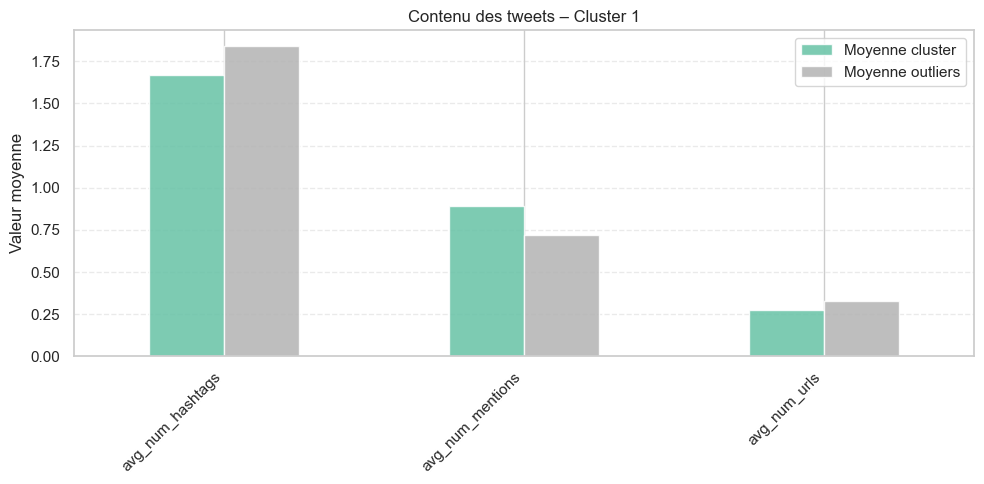

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from pymongo import MongoClient

# Connexion à MongoDB
client = MongoClient("localhost", 27017)
db = client["IF29_twitter_db"]

# Chargement des données nécessaires
outliers_df = pd.DataFrame(list(db["acp_outliers"].find()))
acp_db_df = pd.DataFrame(list(db["acp_db"].find({}, {"_id": 1, "user_id": 1})))
user_db_df = pd.DataFrame(list(db["user_db"].find()))
clusters_df = pd.DataFrame(list(db["acp_clusters"].find()))

# Merges pour enrichir
outliers_df = pd.merge(outliers_df, acp_db_df, on="_id", how="left")
outliers_df = pd.merge(outliers_df, user_db_df, left_on="user_id", right_on="_id", how="left")
clusters_df = pd.merge(clusters_df, acp_db_df, on="_id", how="left")
clusters_df = pd.merge(clusters_df, user_db_df, left_on="user_id", right_on="_id", how="left")

# Groupes de variables
groupes = {
    "Engagement & Activité": [
        "followers_count", "friends_count", "favourites_count", "statuses_count"
    ],
    "Tweets Per Day": ["tweets_per_day"],
    "Ratio Engagement": ["engagement_ratio"],
    "Ratios followers friends": ["followers_friends_ratio"],
    "avg_text_length": ["avg_text_length"],
    "Contenu des tweets": [
        "avg_num_hashtags", "avg_num_mentions", "avg_num_urls"
    ]
}

# Pour chaque cluster
for cluster_id in sorted(clusters_df["cluster"].dropna().unique()):
    print(f"\n Graphe pour le Cluster {cluster_id}")
    
    cluster_all = clusters_df[clusters_df["cluster"] == cluster_id]
    cluster_outliers = outliers_df[outliers_df["cluster"] == cluster_id]
    
    for nom_groupe, colonnes in groupes.items():
        all_means = cluster_all[colonnes].mean()
        outlier_means = cluster_outliers[colonnes].mean()

        df_group = pd.DataFrame({
            "Moyenne cluster": all_means,
            "Moyenne outliers": outlier_means
        })

        df_group.plot(kind="bar", figsize=(10, 5), colormap="Set2", alpha=0.85)
        plt.title(f"{nom_groupe} – Cluster {cluster_id}")
        plt.ylabel("Valeur moyenne")
        plt.xticks(rotation=45, ha="right")
        plt.grid(axis="y", linestyle="--", alpha=0.4)
        plt.tight_layout()
        plt.show()


2676 outliers chargés depuis acp_outliers

 26.94% des outliers ont ≥ 3 dimensions avec z-score > ±2


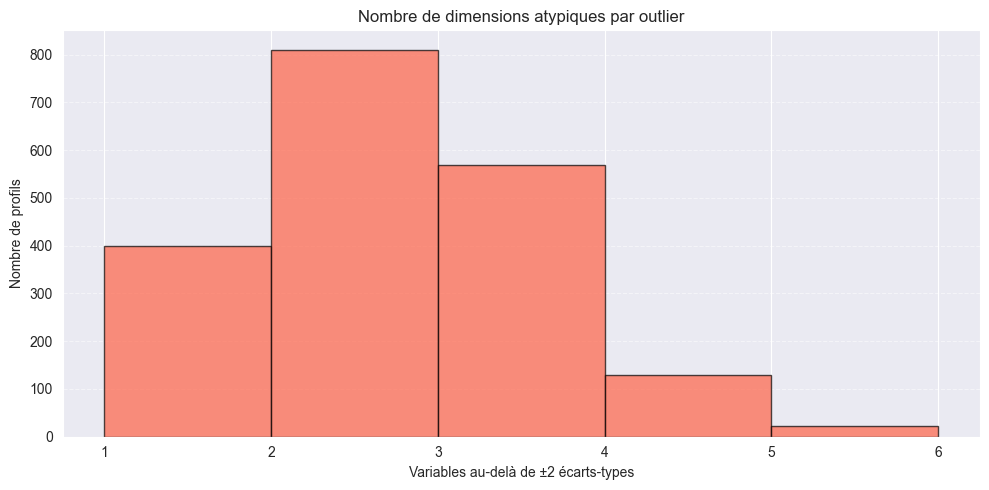

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pymongo import MongoClient

# === Connexion MongoDB ===
client = MongoClient("localhost", 27017)
db = client["IF29_twitter_db"]

# === Étape 1 : Charger les outliers (avec cluster) ===
outliers_df = pd.DataFrame(list(db["acp_outliers"].find()))
print(f"{len(outliers_df)} outliers chargés depuis acp_outliers")

# === Étape 2 : Associer user_id via acp_db ===
acp_db_df = pd.DataFrame(list(db["acp_db"].find({}, {"_id": 1, "user_id": 1})))
outliers_df = pd.merge(outliers_df, acp_db_df, on="_id", how="left")

# === Étape 3 : Enrichir avec user_db ===
user_db_df = pd.DataFrame(list(db["user_db"].find()))
outliers_enriched = pd.merge(outliers_df, user_db_df, left_on="user_id", right_on="_id", how="left")

# === Étape 4 : Construire la base globale par cluster ===
acp_clusters_df = pd.DataFrame(list(db["acp_clusters"].find({}, {"_id": 1, "cluster": 1})))
acp_db_user_df = pd.merge(acp_db_df, acp_clusters_df, on="_id", how="left")
all_users_df = pd.merge(acp_db_user_df, user_db_df, left_on="user_id", right_on="_id", how="left")

# === Étape 5 : Définir les variables d’analyse ===
variables = [
    "followers_count", "friends_count", "statuses_count", "favourites_count",
    "tweets_per_day", "engagement_ratio", "followers_friends_ratio", 
    "favorites_per_tweet", "popularity_score"
]

# === Étape 6 : Moyenne & écart-type par cluster ===
cluster_stats = all_users_df.groupby("cluster")[variables].agg(['mean', 'std'])

# === Étape 7 : Calcul des z-scores pour chaque outlier ===
for var in variables:
    mean_map = outliers_enriched["cluster"].map(cluster_stats[var]["mean"])
    std_map = outliers_enriched["cluster"].map(cluster_stats[var]["std"])
    outliers_enriched[f"{var}_z"] = (outliers_enriched[var] - mean_map) / std_map

# === Étape 8 : Compter les dimensions atypiques par individu ===
z_cols = [col for col in outliers_enriched.columns if col.endswith("_z")]
outliers_enriched["nb_atypical_dimensions"] = outliers_enriched[z_cols].apply(
    lambda row: (abs(row) > 2).sum(), axis=1
)

# === Étape 9 : Résumé global ===
percent = (outliers_enriched["nb_atypical_dimensions"] >= 3).mean() * 100
print(f"\n {percent:.2f}% des outliers ont ≥ 3 dimensions avec z-score > ±2")

# === (Optionnel) Histogramme visuel ===
plt.figure(figsize=(10, 5))
outliers_enriched["nb_atypical_dimensions"].hist(
    bins=range(1, outliers_enriched["nb_atypical_dimensions"].max() + 2),
    edgecolor="black", color="tomato", alpha=0.7
)
plt.title("Nombre de dimensions atypiques par outlier")
plt.xlabel("Variables au-delà de ±2 écarts-types")
plt.ylabel("Nombre de profils")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("images/zscore_atypical_dimensions.png")
plt.show()


2025-06-13 11:48:19,779 - INFO - Début du pipeline de clustering MiniBatch K-Means
2025-06-13 11:48:21,414 - INFO - 267468 vecteurs ACP chargés
2025-06-13 11:48:21,425 - INFO - Échantillon pour évaluation silhouette : 53494 lignes
2025-06-13 11:48:24,307 - INFO - Données clusterisées exportées dans 'acp_clustersk4'


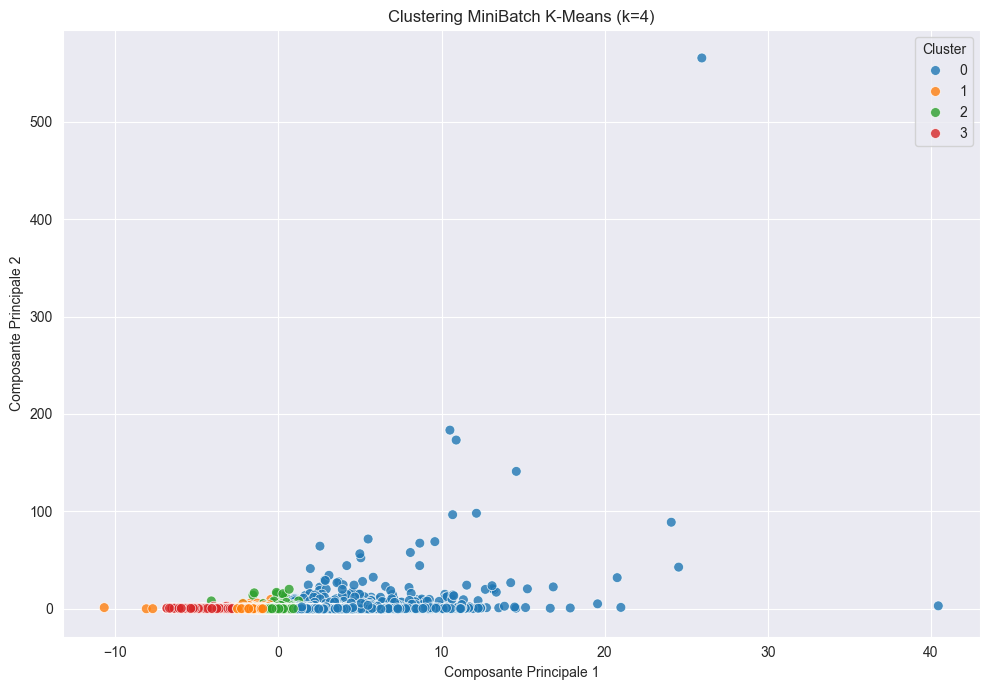

2025-06-13 11:48:42,569 - INFO - Visualisation sauvegardée : clustersK4_acp_pc1_pc2.png
2025-06-13 11:48:42,603 - INFO - Connexion MongoDB fermée
2025-06-13 11:48:42,604 - INFO - Pipeline MiniBatch K-Means terminé avec succès
2025-06-13 11:48:42,605 - INFO - Pipeline MiniBatch K-Means terminé avec succès


In [2]:
import os
import logging
from datetime import datetime
from pymongo import MongoClient
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Environnement
def setup_environment():
    for folder in ["logs", "images"]:
        os.makedirs(folder, exist_ok=True)
    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s - %(levelname)s - %(message)s",
        handlers=[
            logging.FileHandler(f"logs/clustering_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log", encoding="utf-8"),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger(__name__)

logger = setup_environment()
logger.info("Début du pipeline de clustering MiniBatch K-Means")

try:
    # 2. Connexion MongoDB & Chargement des données ACP
    client = MongoClient("localhost", 27017)
    db = client["IF29_twitter_db"]
    collection = db["acp_db"]
    
    # Charger uniquement les composantes principales
    fields = {"_id": 1, "PC1": 1, "PC2": 1, "PC3": 1, "PC4": 1, "PC5": 1}
    data = pd.DataFrame(list(collection.find({}, fields)))
    
    if data.empty:
        raise ValueError("Aucune donnée trouvée dans 'acp_db'")

    id_list = data.pop("_id")
    logger.info(f"{len(data)} vecteurs ACP chargés")

    # 3. Sous-échantillonnage pour recherche de k optimal
    sample_frac = 0.2 if len(data) > 10000 else 1.0
    data_sample = data.sample(frac=sample_frac, random_state=42)
    logger.info(f"Échantillon pour évaluation silhouette : {len(data_sample)} lignes")

    # 4. Détermination du meilleur k (score silhouette)
    best_k=4
    # 5. Clustering complet sur tous les points
    final_model = MiniBatchKMeans(
        n_clusters=best_k,
        random_state=42,
        batch_size=2048,
        n_init="auto",
        max_no_improvement=20
    )
    data["cluster"] = final_model.fit_predict(data)
    data.insert(0, "_id", id_list)

    # 6. Export MongoDB
    db.drop_collection("acp_clustersk4")
    db["acp_clustersk4"].insert_many(data.to_dict("records"))
    logger.info("Données clusterisées exportées dans 'acp_clustersk4'")

    # 7. Visualisation (PC1 vs PC2)
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=data, x="PC1", y="PC2", hue="cluster", palette="tab10", s=50, alpha=0.8)
    plt.title(f"Clustering MiniBatch K-Means (k={best_k})")
    plt.xlabel("Composante Principale 1")
    plt.ylabel("Composante Principale 2")
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.savefig("images/clustersK4_acp_pc1_pc2.png")
    plt.show()
    plt.close()
    logger.info("Visualisation sauvegardée : clustersK4_acp_pc1_pc2.png")
    ####
    
except Exception as e:
    logger.error(f"Erreur dans le pipeline : {str(e)}")
    raise

finally:
    if "client" in locals():
        client.close()
        logger.info("Connexion MongoDB fermée")

logger.info("Pipeline MiniBatch K-Means terminé avec succès")
logger.info("Pipeline MiniBatch K-Means terminé avec succès")
